In [30]:
import json
import pandas as pd

entity_data = pd.read_csv("asset/product-list.csv")
list(entity_data['product'])

entity_data_json = json.dumps({
    "product":list(entity_data['product'])
    },indent=4)
with open("asset/entity.json","w") as file:
    file.write(entity_data_json)

In [31]:
import json

with open ("asset/entity.json") as file:
    data = json.load(file)

In [32]:
import spacy
nlp = spacy.load('en_core_web_sm')
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner)
else:
    ner = nlp.create_pipe('ner')

In [33]:
from tracemalloc import start
import pandas as pd

ner_data = pd.read_csv("asset/Product-NER.csv")
data , char_start, char_end = list (ner_data.question),list(ner_data.start),list(ner_data.end)
for idx, elem in enumerate(data):
    print("-"+elem[char_start[idx]:char_end[idx]]+"-")

-10 Year Audit Log Retention Add On-
-Advanced Communications-
-Advanced eDiscovery Storage-
-AI Builder Capacity add on-
-Azure Active Directory Premium P1-
-Azure Active Directory Premium P2-
-Azure Information Protection Premium P1-
-Business Apps free-
-Chat session for Virtual Agent-
-Common Area Phone-
-Common Data Service Database Capacity-
-Common Data Service File Capacity-
-Common Data Service Log Capacity-
-Dynamics 365 Operations Order Lines-
-Dynamics 365 Asset Management Addl Assets-
-Dynamics 365 Business Central Additional Environment Addon-
-Dynamics 365 Business Central Database Capacity Overage-
-Dynamics 365 Business Central Database Capacity 100GB-
-Dynamics 365 Business Central Database Capacity-
-Dynamics 365 Business Central Device-
-Dynamics 365 Business Central Essentials-
-Dynamics 365 Business Central External Accountant-
-Dynamics 365 Business Central Premium-
-Dynamics 365 Business Central Team Members-
-Dynamics 365 Commerce-
-Dynamics 365 Commerce Attach

CNER Training data Format:
```
[('training sentence',{'entities': [(start-char, end-char, 'entity-code')]})]
```

In [34]:
CNER_training_data = []
for sentence, start_char, end_char in zip(data, char_start, char_end):
    temp = (
        sentence,{
            "entities":[
                (start_char,end_char,"PRODUCT")
            ]
        }
    )
    CNER_training_data.append(temp)


In [35]:
CNER_training_data_json = json.dumps({
    "data":CNER_training_data
},indent=4)
with open("asset/product_ner_training_data.json","w") as file:
    file.write(CNER_training_data_json)

In [36]:
def json_to_CNER_training_data(json_data):
    entities = []
    for elem in json_data:
        temp =[]
        for loc in elem[1]['entities']:
            temp.append(tuple(loc))
        entities.append({
            "entities":temp
        })
    refined_data = []
    for idx,elem in enumerate(json_data):
        refined_data.append(
            tuple([elem[0],entities[idx]])
        )
    return refined_data

In [37]:
with open("asset/product_ner_training_data.json","r") as file:
    file = json.load(file)
CNER_training_data=  json_to_CNER_training_data(file['data'])
CNER_training_data

[('what is the price of 10 Year Audit Log Retention Add On',
  {'entities': [(21, 55, 'PRODUCT')]}),
 ('what is the price of Advanced Communications',
  {'entities': [(21, 44, 'PRODUCT')]}),
 ('what is the price of Advanced eDiscovery Storage',
  {'entities': [(21, 48, 'PRODUCT')]}),
 ('what is the price of AI Builder Capacity add on',
  {'entities': [(21, 47, 'PRODUCT')]}),
 ('what is the price of Azure Active Directory Premium P1',
  {'entities': [(21, 54, 'PRODUCT')]}),
 ('what is the price of Azure Active Directory Premium P2',
  {'entities': [(21, 54, 'PRODUCT')]}),
 ('what is the price of Azure Information Protection Premium P1',
  {'entities': [(21, 60, 'PRODUCT')]}),
 ('what is the price of Business Apps free',
  {'entities': [(21, 39, 'PRODUCT')]}),
 ('what is the price of Chat session for Virtual Agent',
  {'entities': [(21, 51, 'PRODUCT')]}),
 ('what is the price of Common Area Phone',
  {'entities': [(21, 38, 'PRODUCT')]}),
 ('what is the price of Common Data Service Databa

In [38]:
import random
import matplotlib.pyplot as plt

def train_spacy(train_data, iterations):
    nlp = spacy.blank('en')
    if 'ner' not in nlp.pipe_names:
        # ner = nlp.create_pipe('ner')
        nlp.add_pipe("ner", last=True)
       
    # Add labels
    for _, annotations in train_data:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # Disable all pipes other than 'ner' during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        
        train_loss = []
        
        # Go through the training data N times
        for itn in range(iterations):
            print("Starting iteration " + str(itn))

            random.shuffle(train_data)

            losses = {}
            misalligned_count = 0

            for batch in spacy.util.minibatch(train_data, size=2):
                for text, annotations in batch:    
                    try:
                        doc = nlp.make_doc(text)
                        example = spacy.training.Example.from_dict(doc, annotations)
                        nlp.update(
                            [example],
                            drop=0.2,
                            sgd=optimizer,
                            losses=losses)

                    except ValueError as e:
                        misalligned_count += 1
                        print(f'Ignoring misaligned entity...\n{(text,annotations)}')
                        pass

                train_loss.append(losses.get('ner'))
                print(f'losses (iteration {itn}): {losses}')
            
        # Visualizing the loss
        plt.figure(figsize=(10,6))
        plt.plot([*range(len(train_loss))], train_loss, color = 'magenta')
        plt.title('Loss at every iteration')
        plt.xlabel('Iteration Number')
        plt.ylabel('Loss')
        plt.show()
            
    return nlp

Starting iteration 0
losses (iteration 0): {'ner': 17.174597918987274}
losses (iteration 0): {'ner': 35.17368859052658}
losses (iteration 0): {'ner': 51.79880118370056}
losses (iteration 0): {'ner': 61.64701667428017}
losses (iteration 0): {'ner': 70.31727193295956}
losses (iteration 0): {'ner': 74.61040335148573}
losses (iteration 0): {'ner': 78.6832308806479}
losses (iteration 0): {'ner': 81.79538637169753}
losses (iteration 0): {'ner': 84.66002847257187}
losses (iteration 0): {'ner': 86.61168950177671}
losses (iteration 0): {'ner': 90.08624826337945}
losses (iteration 0): {'ner': 92.61469719734288}
losses (iteration 0): {'ner': 127.20146581389767}
losses (iteration 0): {'ner': 142.18936536203896}
losses (iteration 0): {'ner': 172.16106131590263}
losses (iteration 0): {'ner': 193.602026219556}
losses (iteration 0): {'ner': 204.5700841498727}
losses (iteration 0): {'ner': 212.09746493985207}
losses (iteration 0): {'ner': 215.02277760537604}
losses (iteration 0): {'ner': 220.5322215082

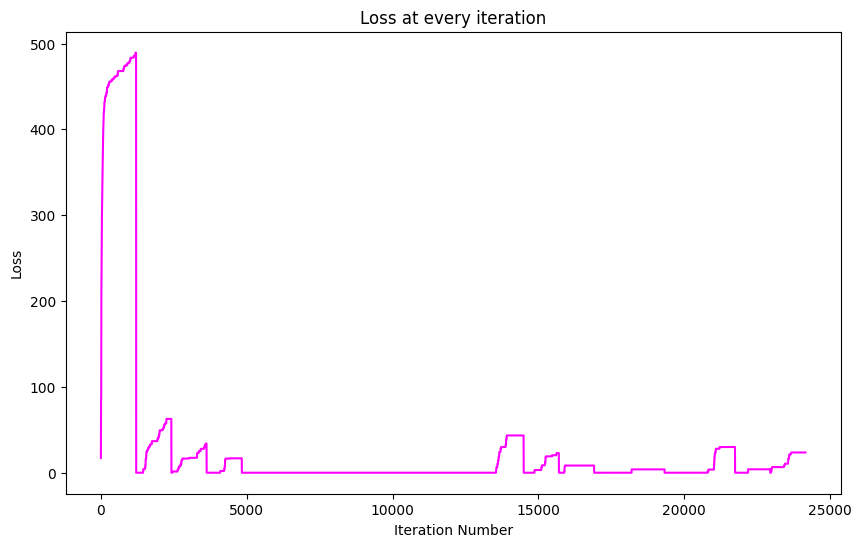

In [39]:
product_nlp = train_spacy(train_data=CNER_training_data,iterations=20)

In [43]:
product_nlp.to_disk("models/product-cner")

In [41]:
from IPython.core.display import display, HTML
from spacy import displacy
def extract_product(user_input, visualize = False):
    product_NLP = product_nlp
    doc = product_NLP(user_input)

    extracted_entities = []
    for ent in doc.ents:
        extracted_entities.append((ent.text, ent.start_char, ent.end_char, ent.label_))

    if visualize == True:
        colors = {"PRODUCT": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
        options = {"ents": ["PRODUCT"], "colors": colors}
        html = displacy.render(doc, style = 'ent', options = options)
        display(HTML(html));
    return extracted_entities

/tmp/ipykernel_1362/3359413098.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [48]:
extract_product("in which subscription my power bi licence is there", visualize = True)

<IPython.core.display.HTML object>

[('power bi licence', 25, 41, 'PRODUCT')]